<font color="orange">Local volatility under rough volatility</font>


The rough Bergomi model is defined as:

\begin{align*}
    dS_t &= S_t \sqrt{\xi_t^t} dW_t^S, \\
    \xi_t^u &= \xi_0^u \exp \left\{
        \eta Y_t^u - \frac{\eta^2}{2} (u^{2H} - (u-t)^{2H})
    \right\}
\end{align*}

where 

$$
    Y_t^u = \sqrt{2H} \int_0^t (u-s)^{H-1/2} dW_s^V.
$$

The correlation between the Brownian motions $W^S$ and $W^V$ is given by $\rho$.

# 1. Imports

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from rbergomi import RoughBergomi
import numpy as np
import utils
from scipy import integrate
import time
import seaborn as sns

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

In [3]:
# Set model parameters and create three instances of the rough Bergomi model with
# H = 0.1, 0.3, and 0.5

list_H = [0.1, 0.3, 0.5]

params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "eta": 1.0,
    "rho": -0.7,
}

rbergomi_models = {f"H={H}": RoughBergomi(**params, H=H) for H in list_H}

In [4]:
colors = {0.1: "blue", 0.3: "green", 0.5: "red"}
markers = {0.1: ".", 0.3: "+", 0.5: "x"}
seed = 1234
maturity = 0.5
n_disc = 200
tab_t = np.linspace(0.0, maturity, n_disc + 1)
dt = tab_t[1] - tab_t[0]
n_mc = 3 * 10**5
n_loop = 1

We compute the: 

- ATM local volatility skew $\partial_k \sigma_{loc}(T,k)|_{k=0}$
- ATM implied volatility skew $\partial_k \sigma_{BS}(T,k)|_{k=0}$ 

and compare them.

In [5]:
n_disc_split = 50

atm_impvols = {}
atm_impvol_skews = {}
atm_lvs = {}
atm_lv_skews = {}

for H in list_H:
    t0 = time.time()
    print("H =", H)
    res = rbergomi_models[f"H={H}"].atm_implied_vol_local_vol_skew(
        tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=seed, n_disc_split=n_disc_split
    )
    atm_impvols[f"H={H}"], atm_impvol_skews[f"H={H}"] = res[1]
    atm_lvs[f"H={H}"], atm_lv_skews[f"H={H}"] = res[2]
    print(f"time taken: {(time.time() - t0):.2f} seconds\n")

H = 0.1
time taken: 13.49 seconds

H = 0.3
time taken: 12.60 seconds

H = 0.5
time taken: 8.08 seconds



In [6]:
tab_t_split = np.array([t[-1] for t in np.split(tab_t[1:], n_disc // n_disc_split)])

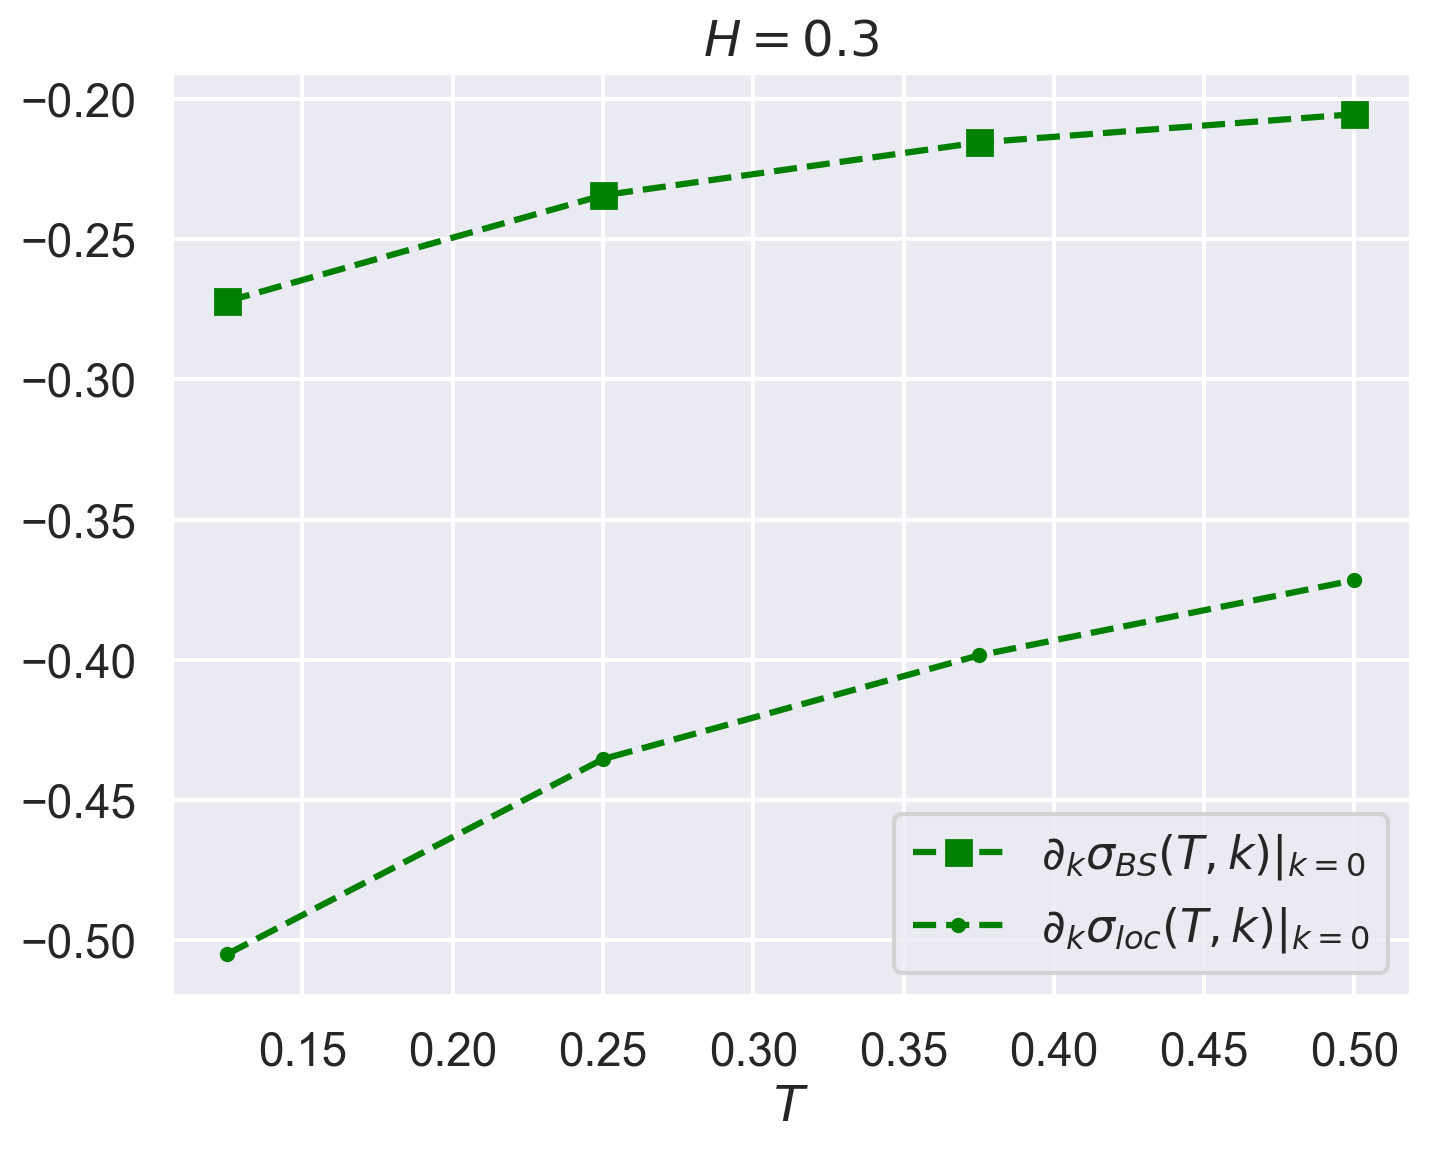

In [7]:
H = 0.3

plt.close()
fig, ax = plt.subplots()
ax.plot(
    tab_t_split,
    atm_impvol_skews[f"H={H}"],
    "--s",
    label="$\\partial_k \\sigma_{BS}(T,k)|_{k=0}$",
    color=colors[H],
)
ax.plot(
    tab_t_split,
    atm_lv_skews[f"H={H}"],
    "--.",
    label="$\\partial_k \\sigma_{loc}(T,k)|_{k=0}$",
    color=colors[H],
)
ax.set_xlabel("$T$")
ax.set_title(f"$H={H}$")
ax.legend()
plt.show()

We want to check the "$H+3/2$" rule, that is

$$
    \frac{\partial_k \sigma_{BS}(T,k)|_{k=0}}{\partial_k \sigma_{loc}(T,k)|_{k=0}}
    \underset{T\to0}{\to} \frac{1}{H+3/2}
$$

In [8]:
tab_t_split

array([0.125, 0.25 , 0.375, 0.5  ])

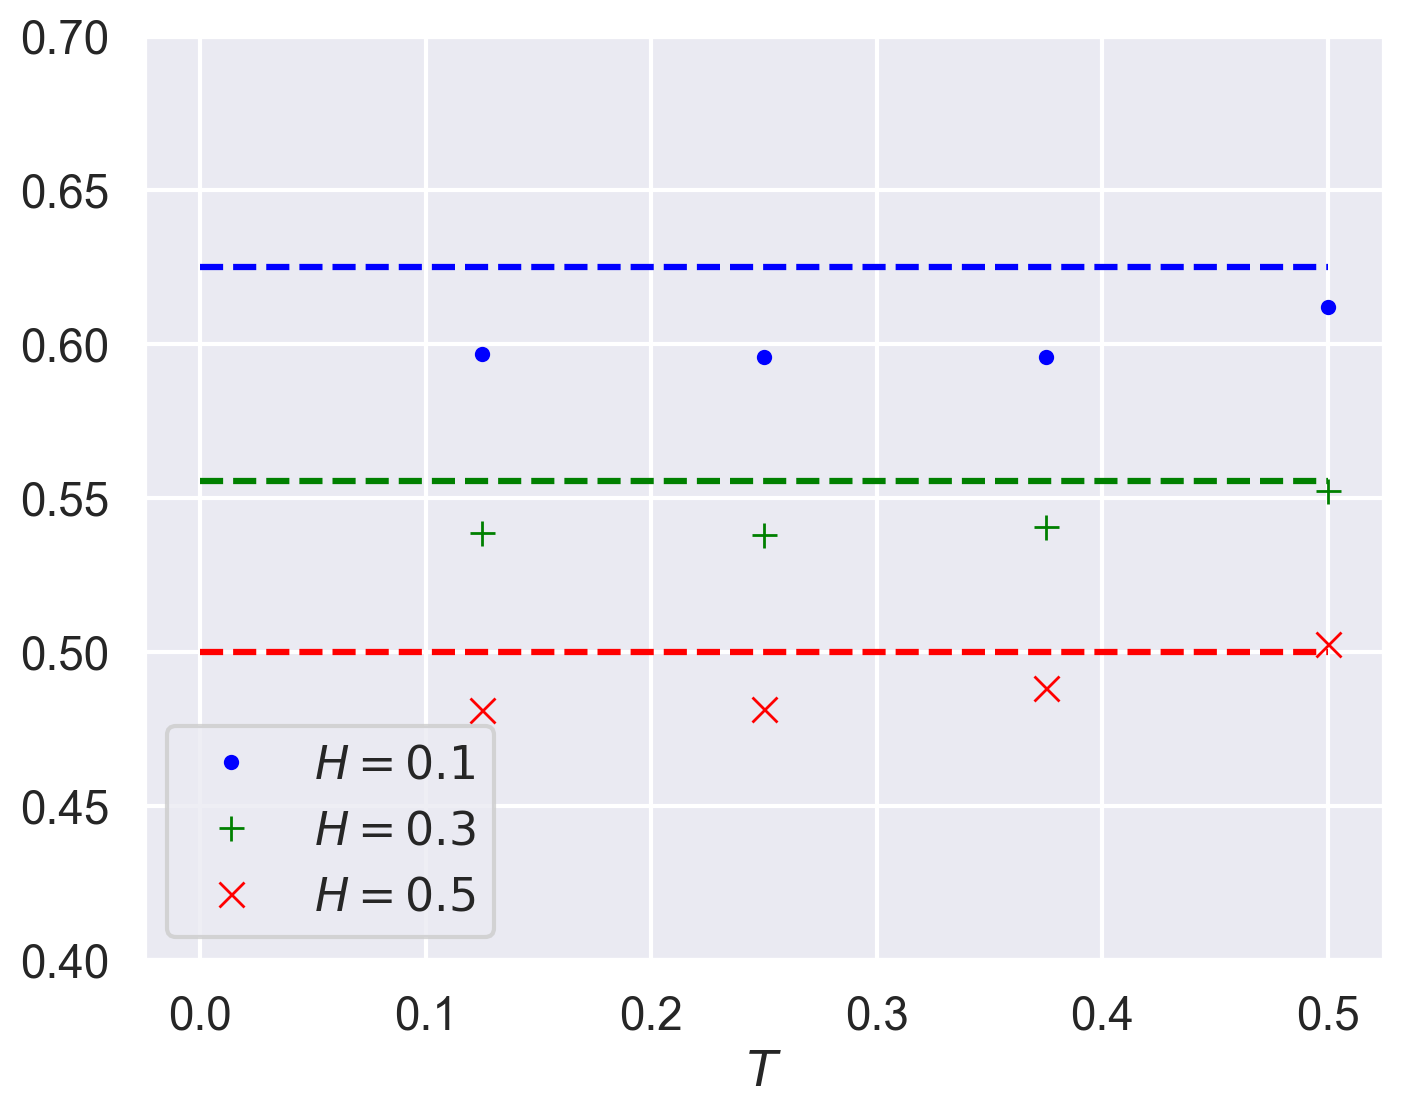

In [9]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6))
for H in list_H:
    ax.plot(
        tab_t_split,
        atm_impvol_skews[f"H={H}"] / atm_lv_skews[f"H={H}"],
        markers[H],
        label=f"$H={H}$",
        color=colors[H],
    )
    ax.plot(tab_t, 1.0 / (H + 1.5) * np.ones_like(tab_t), "--", color=colors[H])
ax.set_xlabel("$T$")
ax.legend(ncol=1)
ax.set_ylim(0.4, 0.7)
plt.show()

We compare the implied volatility $\sigma_{BS}(T,k)$ and the harmonic mean
$H(T,k)$ of the local volatility $\sigma_{loc}(T,k)$ defined as 

$$
    H(T,k) = \left(\frac{1}{k}\int_0^k \frac{dy}{\sigma_{loc}(T,y)}\right)^{-1}
$$

In [10]:
H = 0.3
T = 0.45

tab_t = np.linspace(0.0, T, n_disc + 1)
paths = rbergomi_models[f"H={H}"].simulate(
    tab_t=tab_t, n_mc=n_mc, n_loop=n_loop, seed=seed, conditioning=True
)


def func_locvol(y):
    return rbergomi_models[f"H={H}"].local_vol_from_paths(
        k=y,
        v_t=paths["v"][-1, :],
        int_v_dt=paths["int_v_dt"],
        int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    )

In [11]:
def harmonic_mean_loc_vol(k):
    if k == 0.0:
        return func_locvol(0.0)[0]
    return 1.0 / (integrate.quad(lambda y: 1.0 / func_locvol(y)[0], 0, k)[0] / k)

In [12]:
tab_k = np.linspace(-0.2, 0.05, 11)

In [13]:
harmo_means = np.array([harmonic_mean_loc_vol(k) for k in tab_k])

In [14]:
impvol = rbergomi_models[f"H={H}"].implied_vol_from_paths(
    k=tab_k,
    T=T,
    int_v_dt=paths["int_v_dt"],
    int_sqrt_v_dw=paths["int_sqrt_v_dw"],
    conditioning=True,
)

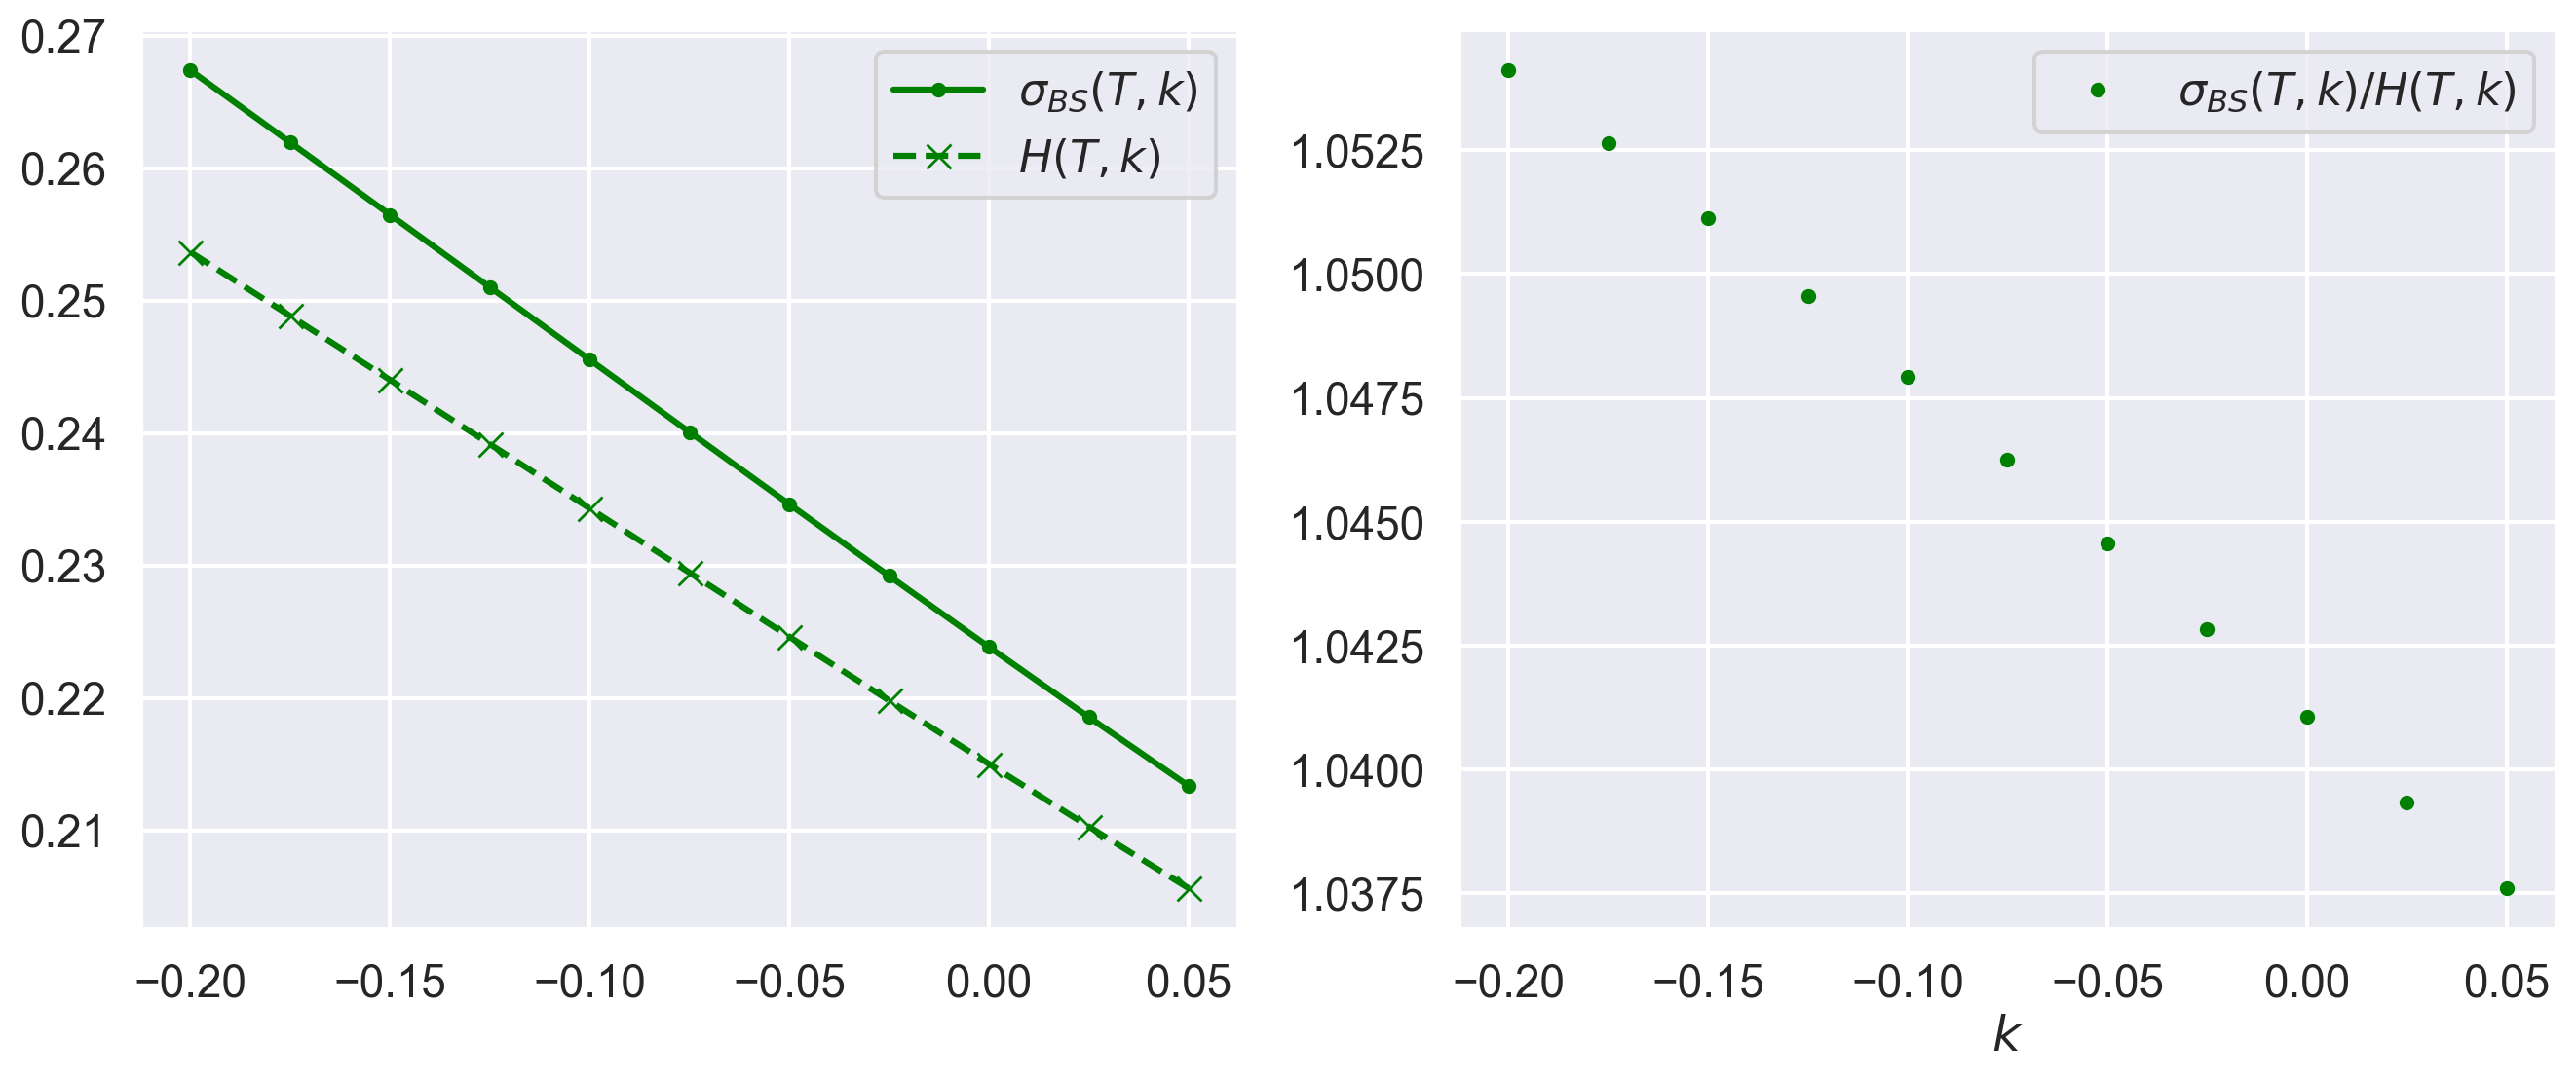

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(tab_k, impvol, ".-", label=r"$\sigma_{BS}(T,k)$", color=colors[H])
ax[0].plot(tab_k, harmo_means, "x--", label="$H(T,k)$", color=colors[H])
ax[0].legend()
ax[1].plot(
    tab_k,
    impvol / harmo_means,
    ".",
    label=r"$\sigma_{BS}(T,k) / H(T,k)$",
    color=colors[H],
)
ax[1].set_xlabel("$k$")
ax[1].legend()
plt.show()

Comparison of $\sigma_{loc}(T,y \, T^{1/2-H})$ and $\sigma(\widehat{h_1^y})$ for 
$T \in \{0.05, 0.2, 0.35, 0.5\}$.

The rate function minimizing path $\widehat{h}_1^y$ is evaluated using the Ritz 
projection method with $N=8$ Fourier basis functions. We refer to section 
4.2. for details.

In [16]:
H = 0.3
print("H =", H, "\n")

n_mc = 1 * 10**5
n_disc = 200
n_loop = 1
y = np.linspace(-0.5, 0.5, 11)
list_T = [0.05, 0.2, 0.35, 0.5]
lv_y = np.zeros((len(list_T), y.shape[0]))

for i, T in enumerate(list_T):
    print("T =", T)
    lv_y[i, :] = rbergomi_models[f"H={H}"].local_vol(
        k=y * T ** (0.5 - H), T=T, n_mc=n_mc, n_disc=n_disc, n_loop=n_loop, seed=seed
    )

H = 0.3 

T = 0.05
T = 0.2
T = 0.35
T = 0.5


In [20]:
rbergomi_models[f"H={0.3}"].kernel_fourier_integrals(n=3, t=0.2)

np.float64(0.6002237380619073)

In [37]:
n_trunc = 8
tab_a, _ = rbergomi_models[f"H={H}"].rate_function(y, N=n_trunc)

iteration 1 of 11
iteration 2 of 11
iteration 3 of 11
iteration 4 of 11
iteration 5 of 11
iteration 6 of 11
iteration 7 of 11
iteration 8 of 11
iteration 9 of 11
iteration 10 of 11
iteration 11 of 11


In [38]:
eta = rbergomi_models[f"H={H}"].eta
sigma_0 = rbergomi_models[f"H={H}"].xi0_0 ** 0.5

In [40]:
x = np.array(
    [
        np.sum(
            tab_a[i, :]
            * rbergomi_models[f"H={H}"].kernel_fourier_integrals(n=n_trunc, t=1.0),
        )
        for i in range(y.shape[0])
    ]
)
sig_h = sigma_0 * np.exp(0.5 * eta * x)

sig_h

array([0.43526676, 0.39255503, 0.35062744, 0.30987371, 0.27094912,
       0.235     , 0.20402111, 0.18117673, 0.17021856, 0.17321023,
       0.18881367])

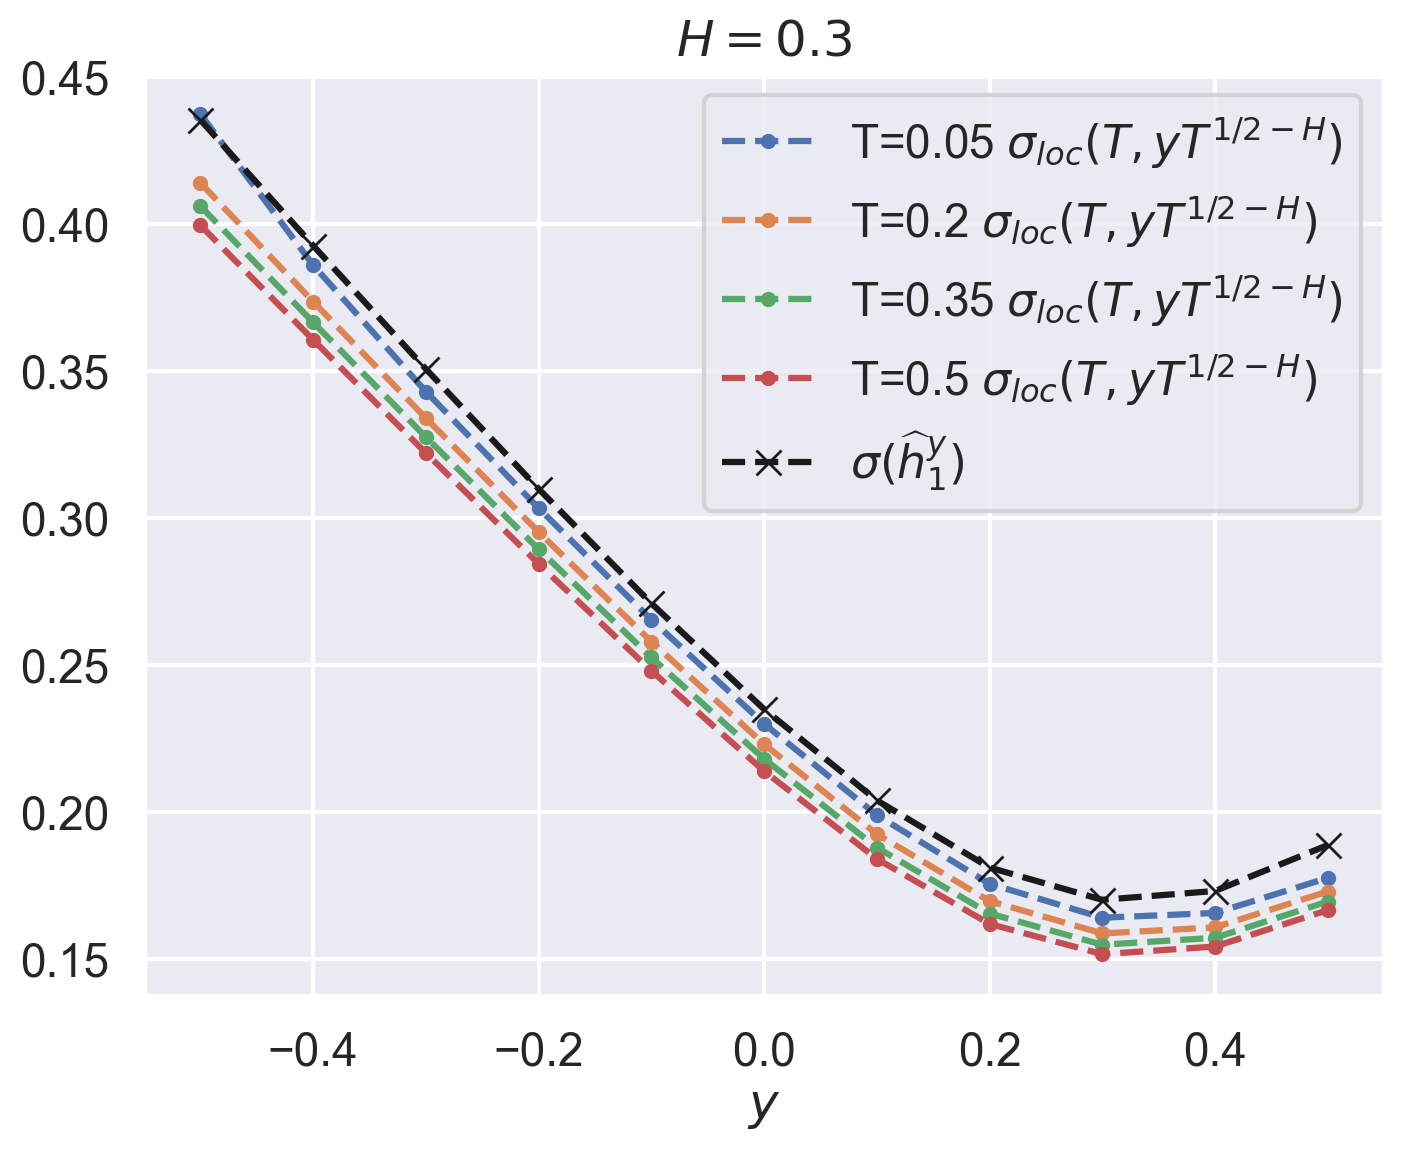

In [41]:
fig, ax = plt.subplots()
for i, T in enumerate(list_T):
    ax.plot(y, lv_y[i, :], ".--", label=f"T={T} " + r"$\sigma_{loc}(T,yT^{1/2-H})$")
ax.plot(y, sig_h, "x--k", label=r"$\sigma(\widehat{h}_1^y)$")
ax.set_xlabel("$y$")
ax.set_title(f"$H={H}$")
ax.legend()
plt.show()

In [70]:
H = 0.3
n = 5
t = 0.2


def func(s):
    return np.cos(2.0 * np.pi * n * s)


def integrand(s):
    return (t - s) ** (H - 0.5) * func(s)


integral = integrate.quad(integrand, 0, t)[0]
print(integral)


0.02149512737509872


Use that 
$\int_0^t (t-s)^{H-1/2} f(s) ds = (t/2)^{H+1/2} \int_{-1}^{1} (1-u)^{H-1/2} f(t(1+u)/2) du$.

In [71]:
from scipy import special

n_quad = 10
nodes, weights = special.roots_jacobi(n_quad, H - 0.5, 0)

(0.5 * t) ** (H + 0.5) * np.dot(weights, func(0.5 * t * (1 + nodes)))

np.float64(0.021495127375099097)